<a href="https://colab.research.google.com/github/JulioLaz/Movie_Recommender_System_ML/blob/main/Movie_Recommender_System_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final
path_img = 'https://i0.wp.com/image.tmdb.org/t/p/w300'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  3739k      0 --:--:-- --:--:-- --:--:-- 3746k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
# df_movies.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/movies.csv', index=False)
df_movies = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/movies.csv')
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [60]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [61]:
# df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
# df_ratings.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/ratings.csv', index=False)
df_ratings = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/ratings.csv')
df_ratings.head()

userId  movieId  rating  timestamp
0       1        1    4.00  964982703
1       1        3    4.00  964981247
2       1        6    4.00  964982224
3       1       47    5.00  964983815
4       1       50    5.00  964982931

In [62]:
# df_links = pd.read_csv('data/ml-latest-small/links.csv')
# df_links.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/links.csv', index=False)
df_links = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/links.csv')
df_links = df_links[['movieId','imdbId']]
df_links['imdbId'] = df_links['imdbId'].apply(lambda x: f"tt{x:07d}")
df_links.head()

movieId     imdbId
0        1  tt0114709
1        2  tt0113497
2        3  tt0113228
3        4  tt0114885
4        5  tt0113041

In [63]:
df_poster=pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/df_merged_poster_links.csv')
df_poster.head()

movieId    imdb_id                       poster_path
0        1  tt0114709  /uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg
1        2  tt0113497  /vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg
2        3  tt0113228  /1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg
3        4  tt0114885  /4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg
4        5  tt0113041  /rj4LBtwQ0uGrpBnCELr716Qo3mw.jpg

In [64]:
df_merge_movies_links = pd.merge(df_movies, df_links, on='movieId')
df_merge_movies_links.head(2)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        2    Jumanji (1995)                   Adventure|Children|Fantasy   

      imdbId  
0  tt0114709  
1  tt0113497

In [65]:
df_merge_movies_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
 3   imdbId   9742 non-null   object
dtypes: int64(1), object(3)
memory usage: 304.6+ KB


In [66]:
df_merge_movies_links[df_merge_movies_links['imdbId']==417]

Empty DataFrame
Columns: [movieId, title, genres, imdbId]
Index: []

##**2.2 Tratamiento de Datos**

In [67]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------


In [68]:
def preprocesamiento():
    global df_movies, df_ratings, df_final

    df_movies = df_movies.dropna()
    df_ratings = df_ratings.dropna()
    df_movies = df_movies.drop_duplicates(subset=['movieId'])
    df_ratings = df_ratings.drop_duplicates(subset=['movieId', 'userId'])
    df_movies['content'] = df_movies['genres'].str.replace('|', ' ')
    df_movies['genre_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))

    df_movies['movieId'] = df_movies['movieId'].astype('uint32')
    df_movies['title'] = df_movies['title'].astype(object)
    df_movies['genres'] = df_movies['genres'].astype(object)
    df_movies['content'] = df_movies['content'].astype(object)
    df_movies['genre_set'] = df_movies['genre_set'].astype(object)

    df_ratings['movieId'] = df_ratings['movieId'].astype('uint32')
    df_ratings['userId'] = df_ratings['userId'].astype('uint32')
    df_ratings['rating'] = df_ratings['rating'].astype(float)
    df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

In [69]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   uint32
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: object(4), uint32(1)
memory usage: 342.6+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  uint32        
 1   movieId    100836 non-null  uint32        
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), uint32(2)
memory usage: 2.3 MB
None
-------------


In [70]:
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   

                                           genre_set  
0  {Children, Animation, Adventure, Fantasy, Comedy}  
1                     {Children, Fantasy, Adventure}  
2                                  {Romance, Comedy}  
3                           {Drama, Romance, Comedy}  
4                                           {Comedy}

In [71]:
2**16

65536

In [72]:
import re

df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)') # Extraer el año de la columna title y crear la nueva columna year
df_movies['year'] = df_movies['year'].fillna(0).astype('uint16')
df_movies['title'] = df_movies['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True) # Dejar sólo el title, eliminando el año:
df_movies.head()
df_movies.head(10)

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   
5        6                         Heat   
6        7                      Sabrina   
7        8                 Tom and Huck   
8        9                 Sudden Death   
9       10                    GoldenEye   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   
5                        Action|Crime|Thriller   
6                               Comedy|Romance   
7                           Adventure|Children   
8                                       Action   
9                    Action|Adventure|Thriller   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   
5                        Action Crime Thriller   
6                               Comedy Romance   
7                           Adventure Children   
8                                       Action   
9                    Action Adventure Thriller   

                                           genre_set  year  
0  {Children, Animation, Adventure, Fantasy, Comedy}  1995  
1                     {Children, Fantasy, Adventure}  1995  
2                                  {Romance, Comedy}  1995  
3                           {Drama, Romance, Comedy}  1995  
4                                           {Comedy}  1995  
5                          {Action, Thriller, Crime}  1995  
6                                  {Romance, Comedy}  1995  
7                              {Children, Adventure}  1995  
8                                           {Action}  1995  
9                      {Action, Adventure, Thriller}  1995

In [73]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   uint32
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
 5   year       9742 non-null   uint16
dtypes: object(4), uint16(1), uint32(1)
memory usage: 361.6+ KB


In [74]:
df_ratings.sample(5)

userId  movieId  rating           timestamp
77455     483     2150    2.00 2008-07-12 20:53:21
3172       20     4901    3.50 2003-05-27 12:08:44
77520     483     2808    2.50 2007-06-10 17:31:16
72804     469     2791    3.00 2000-08-03 21:09:40
42386     288     1584    4.00 2000-12-01 17:34:04

##**2.3 Análisis Exploratorio (EDA)**

In [75]:
df_movies.describe()

movieId    year
count   9742.00 9742.00
mean   42200.35 1991.95
std    52160.49   75.14
min        1.00    0.00
25%     3248.25 1987.00
50%     7300.00 1999.00
75%    76232.00 2008.00
max   193609.00 2018.00

In [76]:
df_ratings.describe()

userId   movieId    rating                      timestamp
count 100836.00 100836.00 100836.00                         100836
mean     326.13  19435.30      3.50  2008-03-19 17:01:27.368469248
min        1.00      1.00      0.50            1996-03-29 18:36:55
25%      177.00   1199.00      3.00            2002-04-18 09:57:46
50%      325.00   2991.00      3.50            2007-08-02 20:31:02
75%      477.00   8122.00      4.00     2015-07-04 07:15:44.500000
max      610.00 193609.00      5.00            2018-09-24 14:27:30
std      182.62  35530.99      1.04                            NaN

##User with the most votes

In [77]:
count_userId=df_ratings['userId'].value_counts()
count_userId.sort_values(ascending=False).head(10)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: count, dtype: int64

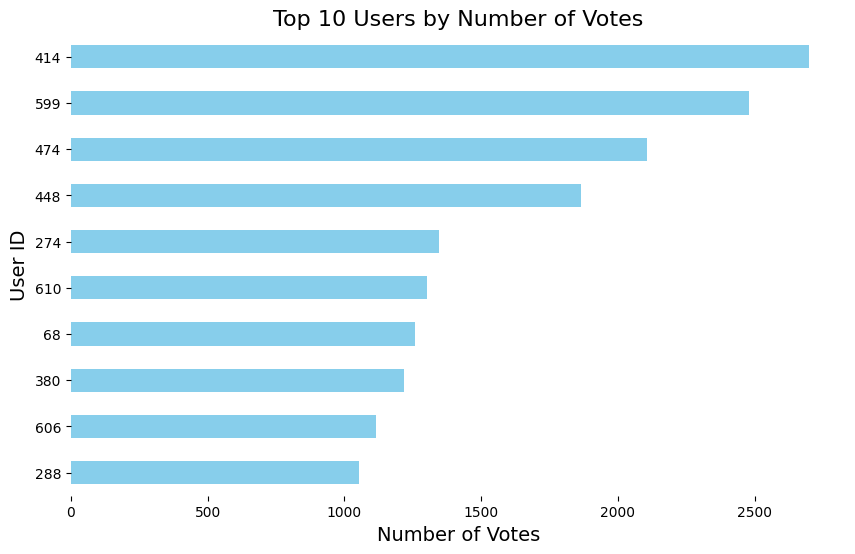

In [78]:
plt.figure(figsize=(10, 6))
count_userId.sort_values(ascending=False).head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Users by Number of Votes', fontsize=16)
plt.xlabel('Number of Votes', fontsize=14)
plt.ylabel('User ID', fontsize=14)
plt.gca().invert_yaxis()
plt.box(None)
plt.show()

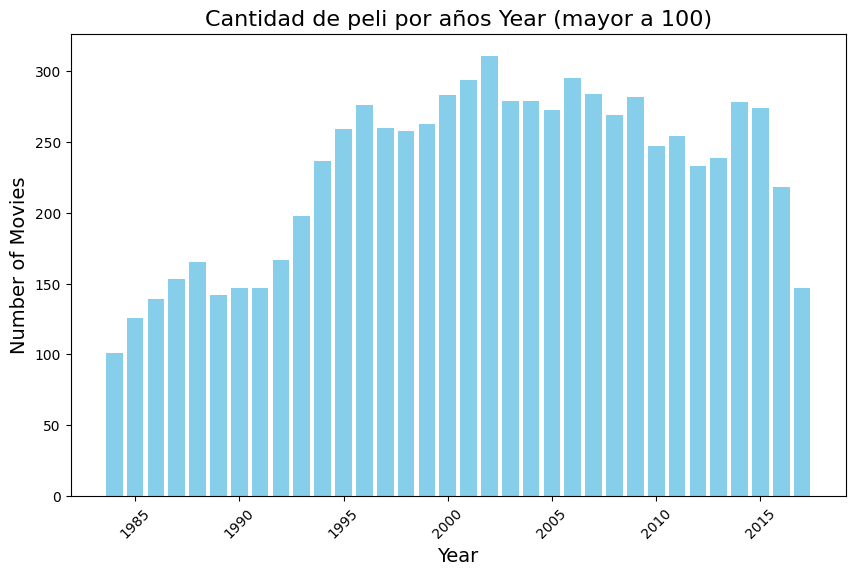

In [79]:
# Histograma del atributo 'years' en df_movies
movie_years=df_movies.groupby('year')['movieId'].count().reset_index()
movie_years=movie_years[movie_years['year']!=0]
movie_years=movie_years[movie_years['movieId']>=100]

plt.figure(figsize=(10, 6))
plt.bar(movie_years['year'], movie_years['movieId'], color='skyblue')

plt.title('Cantidad de peli por años Year (mayor a 100)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45)
plt.show()

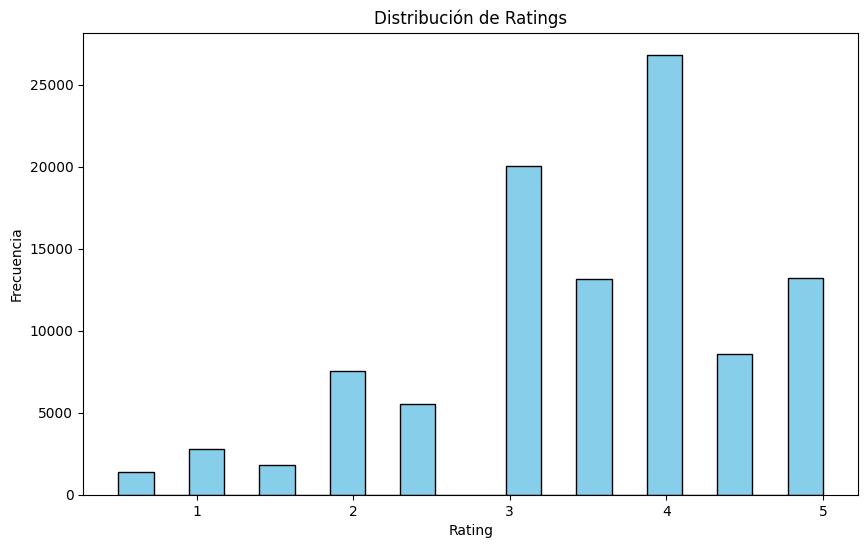

In [80]:
# Histograma del atributo 'rating' en df_ratings
plt.figure(figsize=(10, 6))
plt.hist(df_ratings['rating'], bins=20, edgecolor='black', color='skyblue')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()


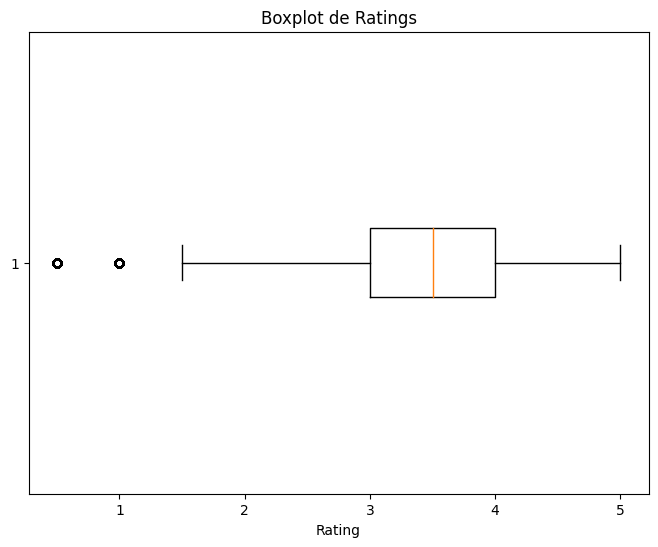

In [81]:
# Boxplot del atributo 'rating' en df_ratings
plt.figure(figsize=(8, 6))
plt.boxplot(df_ratings['rating'], vert=False)
plt.title('Boxplot de Ratings')
plt.xlabel('Rating')
plt.show()


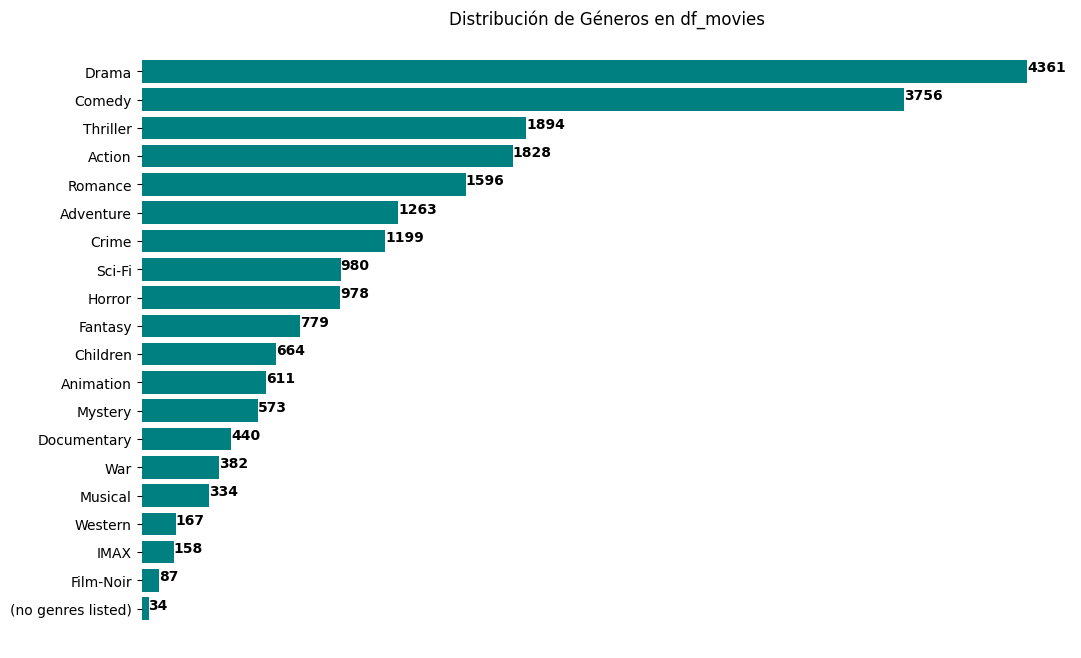

In [82]:
from collections import Counter # Contar la frecuencia de cada género en df_movies

genres = df_movies['genres'].str.split('|').explode()
genre_counts = Counter(genres)
df_genres = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
df_genres.sort_values(by='Count', ascending=True, inplace=True)

plt.figure(figsize=(12, 8))
plt.barh(df_genres.index, df_genres.Count, color='teal')

for i, v in enumerate(df_genres.Count):
    plt.text(v, i, str(v), color='black', fontweight='bold')

plt.title('Distribución de Géneros en df_movies')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.box(False)
plt.show()


In [83]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')
df_final.dropna(inplace=True)
df_final.head()

userId  movieId  rating           timestamp      title  \
0       1        1    4.00 2000-07-30 18:45:03  Toy Story   
1       5        1    4.00 1996-11-08 06:36:02  Toy Story   
2       7        1    4.50 2005-01-25 06:52:26  Toy Story   
3      15        1    2.50 2017-11-13 12:59:30  Toy Story   
4      17        1    4.50 2011-05-18 05:28:03  Toy Story   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1  Adventure|Animation|Children|Comedy|Fantasy   
2  Adventure|Animation|Children|Comedy|Fantasy   
3  Adventure|Animation|Children|Comedy|Fantasy   
4  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1  Adventure Animation Children Comedy Fantasy   
2  Adventure Animation Children Comedy Fantasy   
3  Adventure Animation Children Comedy Fantasy   
4  Adventure Animation Children Comedy Fantasy   

                                           genre_set  year  
0  {Children, Animation, Adventure, Fantasy, Comedy}  1995  
1  {Children, Animation, Adventure, Fantasy, Comedy}  1995  
2  {Children, Animation, Adventure, Fantasy, Comedy}  1995  
3  {Children, Animation, Adventure, Fantasy, Comedy}  1995  
4  {Children, Animation, Adventure, Fantasy, Comedy}  1995

In [84]:
df_final.describe()

userId   movieId    rating                      timestamp      year
count 100836.00 100836.00 100836.00                         100836 100836.00
mean     326.13  19435.30      3.50  2008-03-19 17:01:27.368469504   1994.09
min        1.00      1.00      0.50            1996-03-29 18:36:55      0.00
25%      177.00   1199.00      3.00            2002-04-18 09:57:46   1990.00
50%      325.00   2991.00      3.50            2007-08-02 20:31:02   1997.00
75%      477.00   8122.00      4.00     2015-07-04 07:15:44.500000   2003.00
max      610.00 193609.00      5.00            2018-09-24 14:27:30   2018.00
std      182.62  35530.99      1.04                            NaN     30.27

In [85]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  uint32        
 1   movieId    100836 non-null  uint32        
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   title      100836 non-null  object        
 5   genres     100836 non-null  object        
 6   content    100836 non-null  object        
 7   genre_set  100836 non-null  object        
 8   year       100836 non-null  uint16        
dtypes: datetime64[ns](1), float64(1), object(4), uint16(1), uint32(2)
memory usage: 5.6+ MB


In [86]:
df_title_count_votes = df_final.groupby('title')['userId'].count().reset_index().nlargest(10, 'userId')
df_title_count_votes.rename(columns={'userId': 'count_votes'}, inplace=True)
df_title_count_votes

title  count_votes
3072                        Forrest Gump          329
7368           Shawshank Redemption, The          317
6657                        Pulp Fiction          307
7454           Silence of the Lambs, The          279
5348                         Matrix, The          278
7767  Star Wars: Episode IV - A New Hope          251
4521                       Jurassic Park          238
1301                          Braveheart          237
8125          Terminator 2: Judgment Day          224
7199                    Schindler's List          220

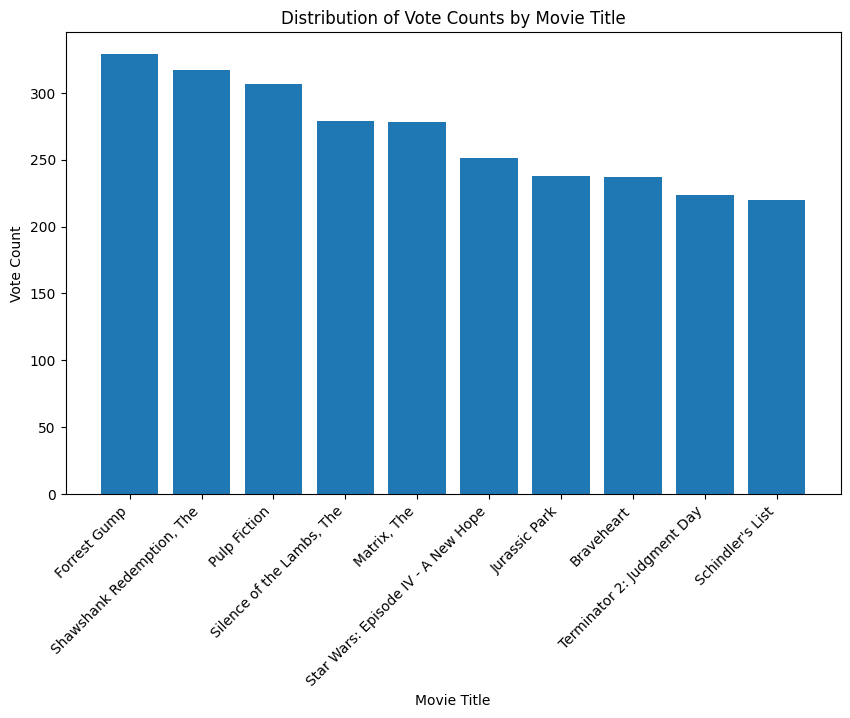

In [87]:
plt.figure(figsize=(10, 6))
plt.bar(df_title_count_votes['title'], df_title_count_votes['count_votes'])
plt.xlabel('Movie Title')
plt.ylabel('Vote Count')
plt.title('Distribution of Vote Counts by Movie Title')
plt.xticks(rotation=45, ha='right')
plt.show()

In [88]:
#agrupar por title con promedio de rating:

df_title_rating = df_final.groupby('title')['rating'].mean().reset_index()
df_title_rating.rename(columns={'rating': 'mean_rating'}, inplace=True)
df_title_rating.sort_values(by='mean_rating', ascending=False, inplace=True)
df_title_rating.sample(10)

title  mean_rating
4589                           Kids Are All Right, The         2.92
2157                                  Daytrippers, The         3.67
3740               Hector and the Search for Happiness         4.25
3090                                        Foxy Brown         2.50
27                                      102 Dalmatians         2.78
741           Bad Lieutenant: Port of Call New Orleans         2.25
329   All About Lily Chou-Chou (Riri Shushu no subete)         3.00
1003                                   Big Bounce, The         2.00
2688                                              Epic         3.00
1391                                       Brown Sugar         1.50

#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

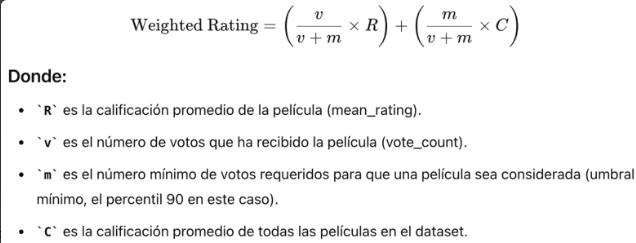

In [89]:
df_final.head(1)

userId  movieId  rating           timestamp      title  \
0       1        1    4.00 2000-07-30 18:45:03  Toy Story   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   

                                           genre_set  year  
0  {Children, Animation, Adventure, Fantasy, Comedy}  1995

In [90]:
def recomendacion_populares():
    vote_counts = df_final['title'].value_counts()
    df_popular_movies = df_final[df_final['title'].isin(vote_counts[vote_counts > 210].index)]
    df_movie_stats = df_popular_movies.groupby(['title','movieId','year']).agg(
        mean_rating=('rating', 'mean'),
        vote_count=('title', 'count')
    ).reset_index()

    m = df_movie_stats['vote_count'].quantile(.9) # Calcular el número mínimo de votos requeridos (m)
    C = df_final['rating'].mean()  # Calcular la calificación promedio de todas las películas (C)
    df_movie_stats['bayesian_average'] = (df_movie_stats['vote_count'] / (df_movie_stats['vote_count'] + m)) * df_movie_stats['mean_rating'] + (m / (df_movie_stats['vote_count'] + m)) * C
    df_movie_stats = df_movie_stats.nlargest(10, 'bayesian_average')
    return df_movie_stats

In [91]:
recomendacion_populares= recomendacion_populares()
df_poster_pop = pd.merge(recomendacion_populares, df_poster, on='movieId', how='left')
df_poster_pop

title  movieId  year  mean_rating  \
0                       Shawshank Redemption, The      318  1994         4.43   
1                                    Pulp Fiction      296  1994         4.20   
2                                    Forrest Gump      356  1994         4.16   
3                                     Matrix, The     2571  1999         4.19   
4              Star Wars: Episode IV - A New Hope      260  1977         4.23   
5                                      Fight Club     2959  1999         4.27   
6                       Silence of the Lambs, The      593  1991         4.16   
7                                Schindler's List      527  1993         4.22   
8  Star Wars: Episode V - The Empire Strikes Back     1196  1980         4.22   
9                                      Braveheart      110  1995         4.03   

   vote_count  bayesian_average    imdb_id                       poster_path  
0         317              3.97  tt0111161  /lyQBXzOQSuE59IsHyhrp0qIiPAz.jpg  
1         307              3.84  tt0110912  /d5iIlFn5s0ImszYzBPb8JPIfbXD.jpg  
2         329              3.84  tt0109830  /arw2vcBveWOVZr6pxd9XTd1TdQa.jpg  
3         278              3.83  tt0133093  /f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg  
4         251              3.83  tt0076759  /6FfCtAuVAW8XJjZ7eWeLibRLWTw.jpg  
5         218              3.82  tt0137523  /pB8BM7pdSp6B6Ih7QZ4DrQ3PmJK.jpg  
6         279              3.81  tt0102926  /uS9m8OBk1A8eM9I042bx8XXpqAq.jpg  
7         220              3.80  tt0108052  /sF1U4EUQS8YHUYjNl3pMGNIQyr0.jpg  
8         211              3.79  tt0080684  /nNAeTmF4CtdSgMDplXTDPOpYzsX.jpg  
9         237              3.73  tt0112573   /or1gBugydmjToAEq7OZY0owwFk.jpg

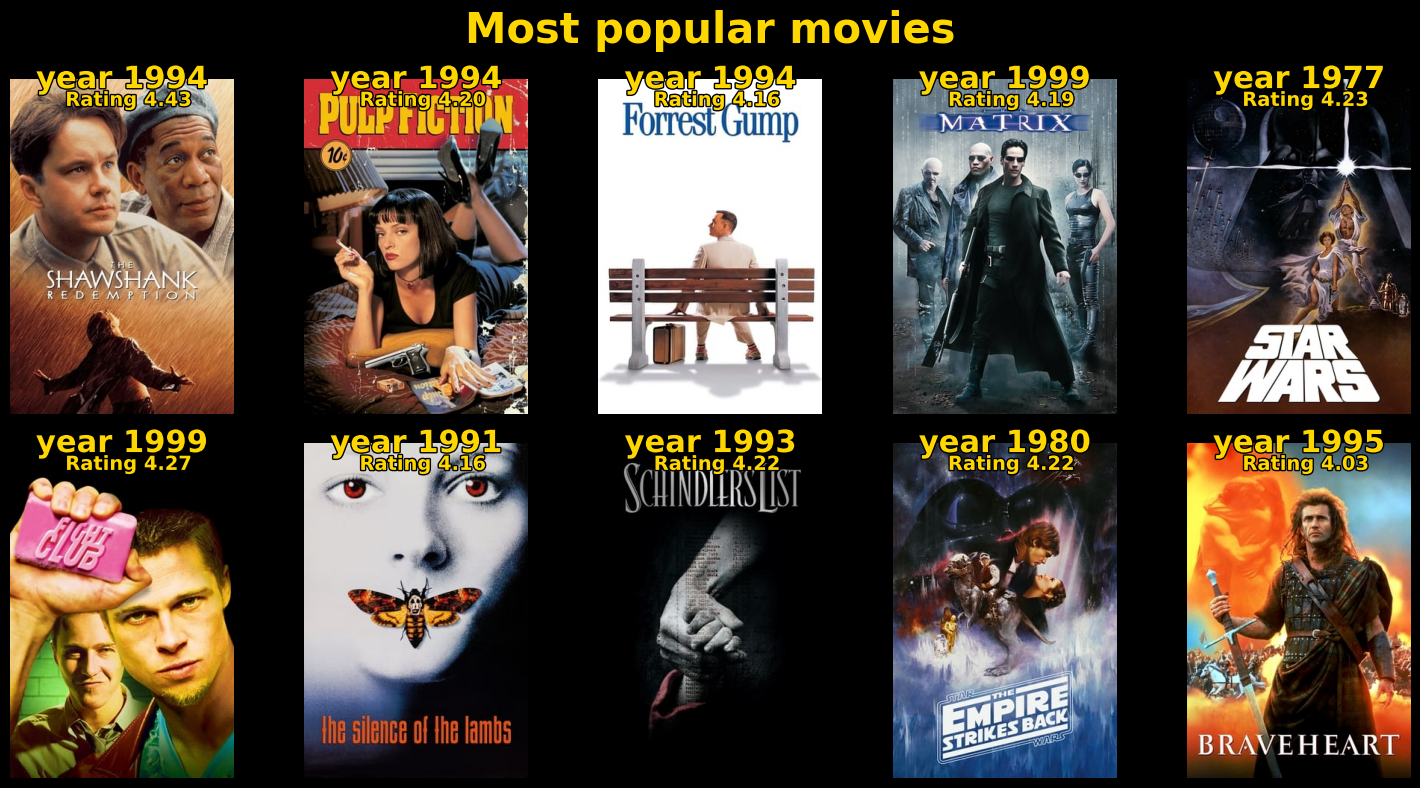

In [92]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO

df_poster_pop['poster_path'] = df_poster_pop['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df_poster_pop.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df_poster_pop['year'], df_poster_pop['mean_rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle(f'Most popular movies', fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**

In [93]:
def similitud_jaccard(set1, set2):
    """Calcula la similitud de Jaccard entre dos conjuntos."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def recomendacion_jaccard(movie_id, df, n_recommendations=10):
    input_features = df[df['movieId'] == movie_id]['genre_set'].values[0]
    df['similaridad'] = df['genre_set'].apply(lambda x: similitud_jaccard(input_features, x))
    df.sort_values('similaridad', ascending=False, inplace=True)
    df=df.nlargest(10,'similaridad')
    df.sort_values('year', ascending=False, inplace=True)
    df_average_ratings=df_ratings.groupby('movieId')['rating'].mean().reset_index()
    df_poster_jaccard = pd.merge(df, df_average_ratings, on='movieId', how='left')
    return df_poster_jaccard


In [94]:
recomendaciones_jaccard = recomendacion_jaccard(58559, df_movies, n_recommendations=10)
df_poster_jaccard = pd.merge(recomendaciones_jaccard, df_poster, on='movieId', how='left')
df_poster_jaccard

movieId                                    title  \
0   109850                           Need for Speed   
1   113416             Revenge of the Green Dragons   
2   120783                             Son of a Gun   
3    86644  Fast Five (Fast and the Furious 5, The)   
4    82744                                   Faster   
5    58559                         Dark Knight, The   
6    73876         Undisputed II: Last Man Standing   
7     6484                       Hollywood Homicide   
8     4488                                   Colors   
9    26464                             Blue Thunder   

                             genres                           content  \
0           Action|Crime|Drama|IMAX           Action Crime Drama IMAX   
1                Action|Crime|Drama                Action Crime Drama   
2                Action|Crime|Drama                Action Crime Drama   
3  Action|Crime|Drama|Thriller|IMAX  Action Crime Drama Thriller IMAX   
4                Action|Crime|Drama                Action Crime Drama   
5           Action|Crime|Drama|IMAX           Action Crime Drama IMAX   
6                Action|Crime|Drama                Action Crime Drama   
7                Action|Crime|Drama                Action Crime Drama   
8                Action|Crime|Drama                Action Crime Drama   
9                Action|Crime|Drama                Action Crime Drama   

                                genre_set  year  similaridad  rating  \
0            {Action, Drama, IMAX, Crime}  2014         1.00    3.75   
1                  {Action, Drama, Crime}  2014         0.75    1.50   
2                  {Action, Drama, Crime}  2014         0.75    2.50   
3  {IMAX, Action, Crime, Drama, Thriller}  2011         0.80    3.05   
4                  {Action, Drama, Crime}  2010         0.75    5.00   
5            {Action, Drama, IMAX, Crime}  2008         1.00    4.24   
6                  {Action, Drama, Crime}  2006         0.75    4.00   
7                  {Action, Drama, Crime}  2003         0.75    2.93   
8                  {Action, Drama, Crime}  1988         0.75    3.33   
9                  {Action, Drama, Crime}  1983         0.75    3.00   

     imdb_id                       poster_path  
0  tt2369135  /z42kyMizgDKetejusZgucSQsQ4l.jpg  
1  tt1396523  /vnM4uANJz8cDLvBZUVFFqfLsIty.jpg  
2  tt2452200  /yRLVyhQfkW2hn15e8NIqarswLAr.jpg  
3  tt1596343  /c5rgA1EYwMmxsQdyvLkQ8LD5Qun.jpg  
4  tt1433108  /AsUeaXrhw4oscCSjUZ6heh1pVvd.jpg  
5  tt0468569  /qJ2tW6WMUDux911r6m7haRef0WH.jpg  
6  tt0443676  /4bE9t5ctBZXYV3GJ6Xr0l4KRplv.jpg  
7  tt0329717  /Am7AhZYG7HLksY5E35oaEJ3Desz.jpg  
8  tt0094894  /5KueYME8A449pxaKTJZp3cWKKSX.jpg  
9  tt0085255  /9tdoGRA7FNCuj1zhKDNLWpab9v5.jpg

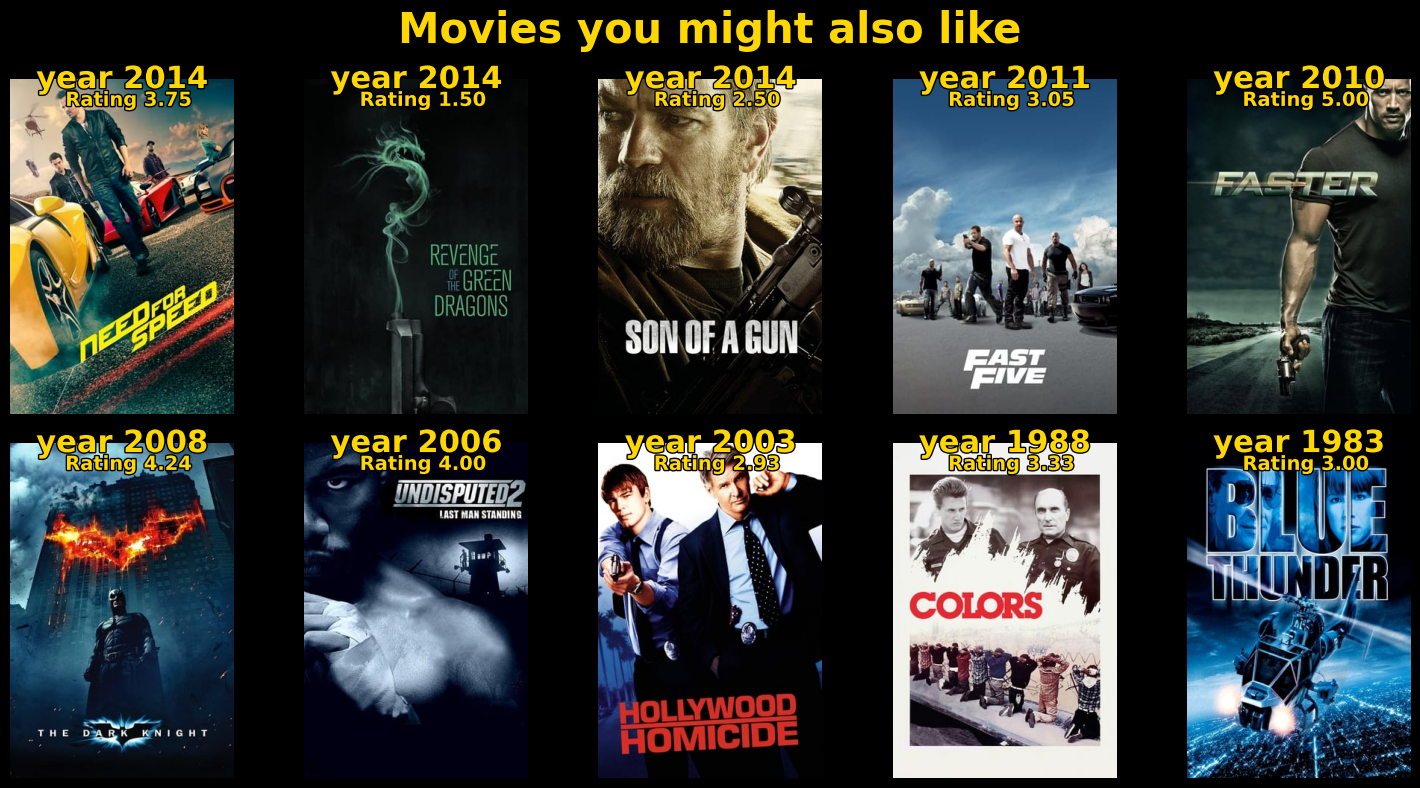

In [95]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO
df=df_poster_jaccard.copy()
df['poster_path'] = df['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df['year'], df['rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle(f'Movies you might also like', fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

###**3.2.2 Similitud de Coseno con TF-IDF**

In [96]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
feature_vectors = vectorizer.fit_transform(df_movies['content'])
cosine_sim = cosine_similarity(feature_vectors,feature_vectors)

In [109]:
def recomendacion_tf_idf(movie_id, df_movies,df_ratings, cosine_sim, n_recommendations=10):
    idx = df_movies[df_movies['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [x for x in sim_scores if x[0] != idx]
    movie_indices = [x[0] for x in sim_scores[:n_recommendations]]
    recommended_movies = df_movies.iloc[movie_indices]
    recommended_movies = recommended_movies.copy()
    recommended_movies['distance'] = [x[1] for x in sim_scores[:n_recommendations]]
    df_average_ratings=df_ratings.groupby('movieId')['rating'].mean().reset_index()
    df_poster_jaccard = pd.merge(recommended_movies, df_average_ratings, on='movieId', how='left')
    df_poster_jaccard.drop(['genres','genre_set','similaridad'], axis=1,inplace=True)
    return df_poster_jaccard

In [111]:
recomendaciones_tfidf = recomendacion_tf_idf(1, df_movies,df_ratings, cosine_sim, n_recommendations=10)
recomendaciones_tfidf = pd.merge(recomendaciones_tfidf, df_poster, on='movieId', how='left')
recomendaciones_tfidf

movieId                                           title  \
0    58559                                Dark Knight, The   
1    33794                                   Batman Begins   
2    86644         Fast Five (Fast and the Furious 5, The)   
3    62081                                       Eagle Eye   
4   100498                         Good Day to Die Hard, A   
5   102716  Fast & Furious 6 (Fast and the Furious 6, The)   
6   102088              Grandmaster, The (Yi dai zong shi)   
7    91529                          Dark Knight Rises, The   
8   104129                                  Man of Tai Chi   
9   103339                                White House Down   

                            content  year  distance  rating    imdb_id  \
0           Action Crime Drama IMAX  2008      1.00    4.24  tt0468569   
1                 Action Crime IMAX  2005      0.96    3.86  tt0372784   
2  Action Crime Drama Thriller IMAX  2011      0.93    3.05  tt1596343   
3        Action Crime Thriller IMAX  2008      0.89    3.06  tt1059786   
4        Action Crime Thriller IMAX  2013      0.89    2.08  tt1606378   
5        Action Crime Thriller IMAX  2013      0.89    3.36  tt1905041   
6                 Action Drama IMAX  2013      0.89    2.00  tt1462900   
7       Action Adventure Crime IMAX  2012      0.87    3.99  tt1345836   
8                       Action IMAX  2013      0.85    3.25  tt2016940   
9        Action Drama Thriller IMAX  2013      0.82    2.92  tt2334879   

                        poster_path  
0  /qJ2tW6WMUDux911r6m7haRef0WH.jpg  
1  /4MpN4kIEqUjW8OPtOQJXlTdHiJV.jpg  
2  /c5rgA1EYwMmxsQdyvLkQ8LD5Qun.jpg  
3  /9KCOv0hL37IN3tWG3j86eZg3xDH.jpg  
4  /evxtv4e8Amm436Y5rW16RkGu8pX.jpg  
5  /thSmnRdrzPBBospIOJjLZBReqzo.jpg  
6  /ydBVVIscL6TsX5hYztA5YpBCwJ3.jpg  
7  /hr0L2aueqlP2BYUblTTjmtn0hw4.jpg  
8  /wnuT1D0fsFu7chFLtcQqwPBaBVg.jpg  
9  /hXLScIERphkTsMGdfKKvF4p4SPB.jpg

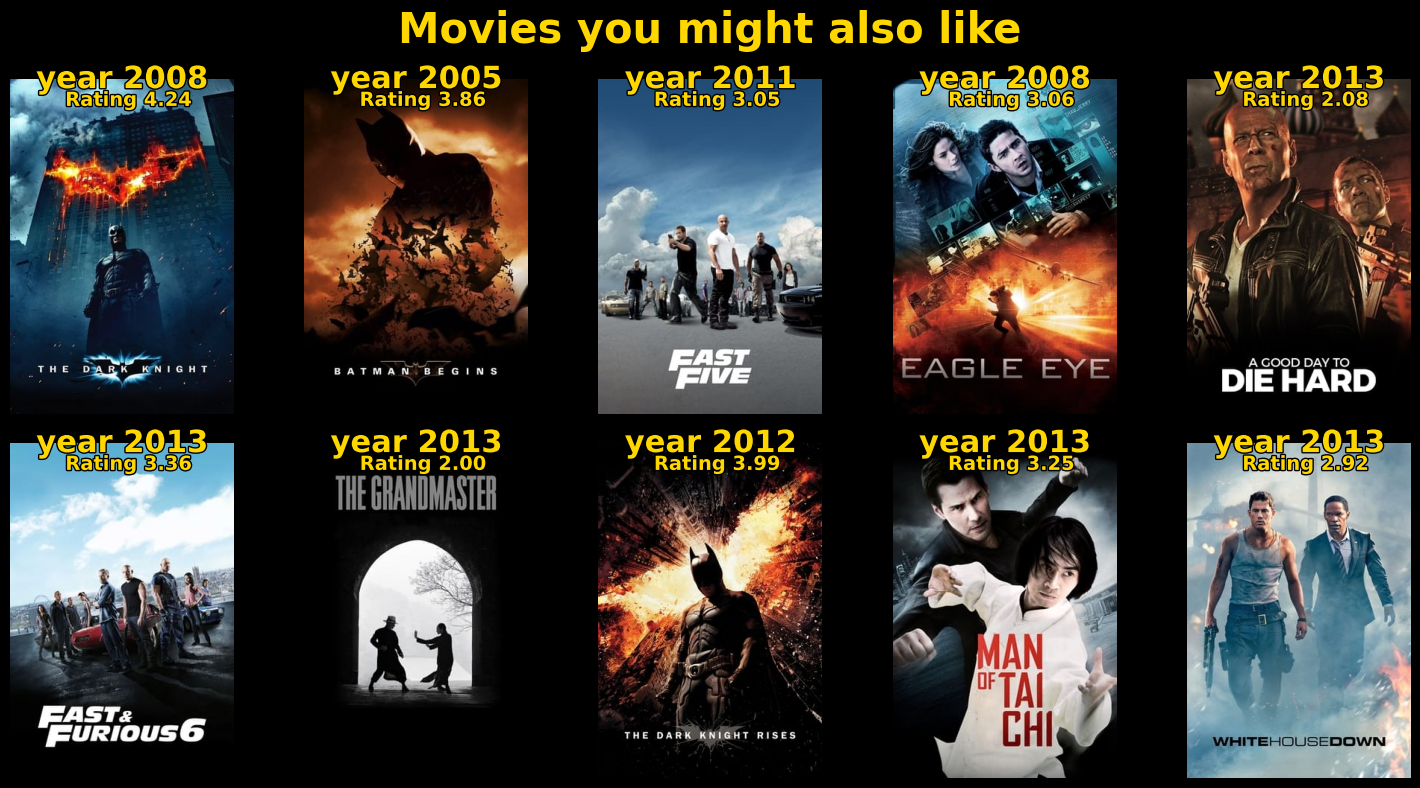

In [112]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO

df=recomendaciones_tfidf.copy()
df['poster_path'] = df['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df['year'], df['rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle(f'Movies you might also like', fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

##**3.3 Recomendación Collaborative Filtering**

In [100]:
#importar NearestNeighbors:
from sklearn.neighbors import NearestNeighbors
ratings_matrix = df_final.pivot(index='userId', columns='movieId', values='rating')
avg_ratings = ratings_matrix.mean(axis=1)
ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0).fillna(0)
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(ratings_matrix_normalized.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [117]:
def recomendacion_knn(user_input, df_final,df_ratings, ratings_matrix_normalized, n_recommendations=10):
    if isinstance(user_input, int):
        print('Existing user',type(user_input))
        idx = ratings_matrix_normalized.index.get_loc(user_input)
        distances, indices = knn_model.kneighbors(ratings_matrix_normalized.iloc[idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    else:
        print('New user',type(user_input))
        new_user_ratings = pd.Series(0, index=ratings_matrix_normalized.columns)
        new_user_ratings.update(usuario)
        user_mean = new_user_ratings[new_user_ratings != 0].mean() # Calculo la media de las calificaciones del usuario
        new_user_ratings_normalized = new_user_ratings.sub(user_mean).fillna(0) # Normalizo calificaciones del usuario
        distances, indices = knn_model.kneighbors(new_user_ratings_normalized.values.reshape(1, -1), n_neighbors=n_recommendations + 1)

    distances = distances.flatten()[1:]# del first element
    indices = indices.flatten()[1:]

    similar_users = ratings_matrix_normalized.iloc[indices] #peli de usuarios similares

    mean_ratings = similar_users.T.dot(distances) / np.sum(distances) #promedio de ratings
    df_mean_ratings = pd.DataFrame(mean_ratings, index=ratings_matrix_normalized.columns, columns=['mean_rating'])
    df_mean_ratings = df_mean_ratings.dropna()

    ### Filtrar peli ya vistas por el user:
    if isinstance(user_input, int):
        movies_seen = df_final[df_final['userId']==user_input].index
        df_mean_ratings = df_mean_ratings[~df_mean_ratings.index.isin(movies_seen)]

    df_mean_ratings = df_mean_ratings.sort_values('mean_rating', ascending=False)

    recommended_movies = pd.merge(df_mean_ratings, df_final[['movieId', 'title', 'content','year']], left_index=True, right_on='movieId')
    recommended_movies.drop_duplicates(subset=['movieId'], inplace=True)
    columnas=['movieId', 'title', 'content','mean_rating','year']
    recommended_movies=recommended_movies[columnas].head(n_recommendations)

    df_average_ratings=df_ratings.groupby('movieId')['rating'].mean().reset_index()
    df_poster_knn = pd.merge(recommended_movies, df_average_ratings, on='movieId', how='left')
    return df_poster_knn

In [119]:
usuario = pd.Series({
    356: 4,
    58559: 5
})
# usuario=15
recomendacion_knn = recomendacion_knn(usuario,df_final,df_ratings, ratings_matrix_normalized, n_recommendations=10)
recomendacion_knn = pd.merge(recomendacion_knn, df_poster, on='movieId', how='left')
recomendacion_knn

New user <class 'pandas.core.series.Series'>


movieId                                  title  \
0      356                           Forrest Gump   
1    58559                       Dark Knight, The   
2      318              Shawshank Redemption, The   
3     2571                            Matrix, The   
4      593              Silence of the Lambs, The   
5      527                       Schindler's List   
6     7361  Eternal Sunshine of the Spotless Mind   
7     1036                               Die Hard   
8     3949                    Requiem for a Dream   
9      587                                  Ghost   

                                 content  mean_rating  year  rating  \
0               Comedy Drama Romance War         1.05  1994    4.16   
1                Action Crime Drama IMAX         0.72  2008    4.24   
2                            Crime Drama         0.51  1994    4.43   
3                 Action Sci-Fi Thriller         0.49  1999    4.19   
4                  Crime Horror Thriller         0.46  1991    4.16   
5                              Drama War         0.32  1993    4.22   
6                   Drama Romance Sci-Fi         0.28  2004    4.16   
7                  Action Crime Thriller         0.27  1988    3.86   
8                                  Drama         0.23  2000    3.92   
9  Comedy Drama Fantasy Romance Thriller         0.23  1990    3.43   

     imdb_id                       poster_path  
0  tt0109830  /arw2vcBveWOVZr6pxd9XTd1TdQa.jpg  
1  tt0468569  /qJ2tW6WMUDux911r6m7haRef0WH.jpg  
2  tt0111161  /lyQBXzOQSuE59IsHyhrp0qIiPAz.jpg  
3  tt0133093  /f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg  
4  tt0102926  /uS9m8OBk1A8eM9I042bx8XXpqAq.jpg  
5  tt0108052  /sF1U4EUQS8YHUYjNl3pMGNIQyr0.jpg  
6  tt0338013  /5MwkWH9tYHv3mV9OdYTMR5qreIz.jpg  
7  tt0095016  /yFihWxQcmqcaBR31QM6Y8gT6aYV.jpg  
8  tt0180093  /nOd6vjEmzCT0k4VYqsA2hwyi87C.jpg  
9  tt0099653  /w9RaPHov8oM5cnzeE27isnFMsvS.jpg

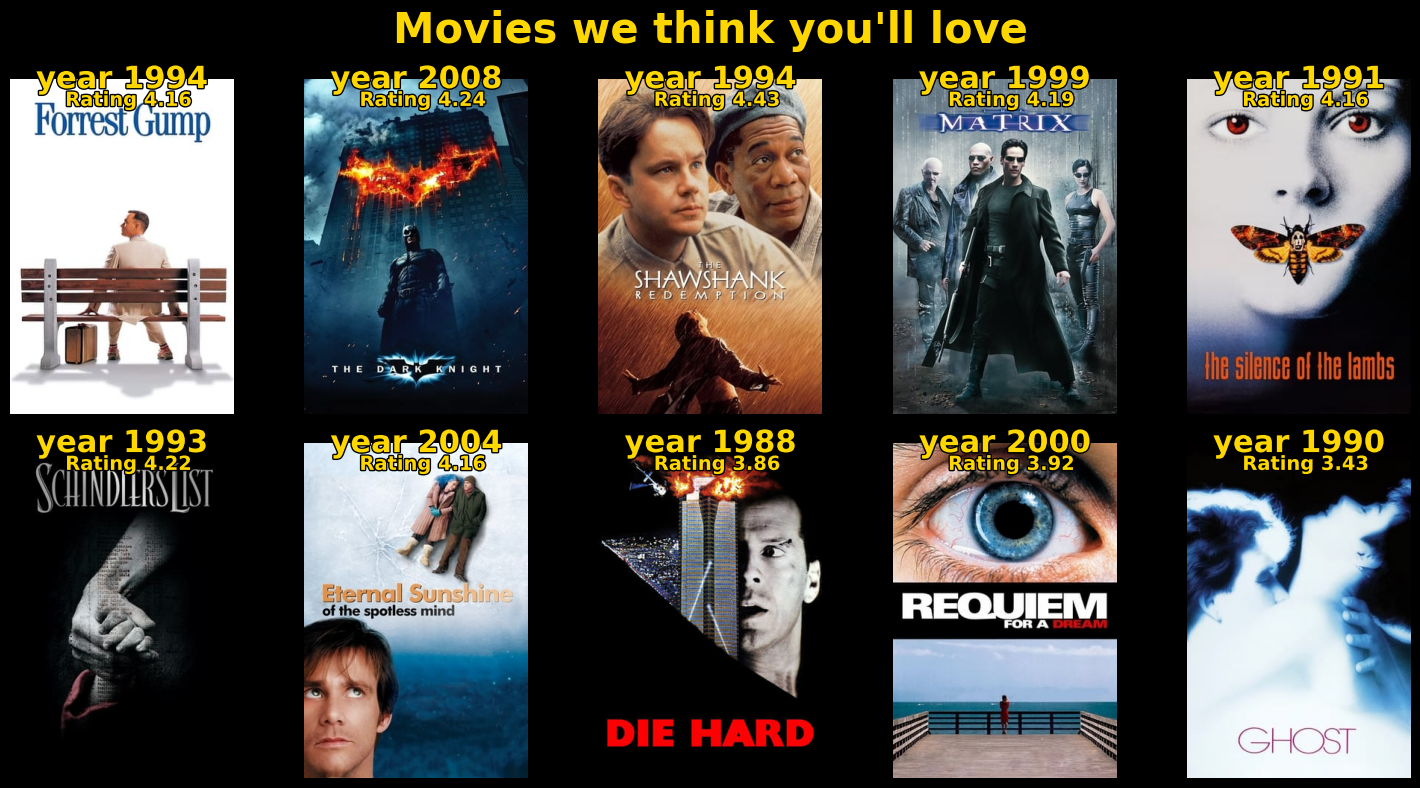

In [121]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO

df=recomendacion_knn.copy()
df['poster_path'] = df['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df['year'], df['rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle("Movies we think you'll love", fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [103]:
#@title
# def recomendacion_knn(usuario_id_o_ratings, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
#   #Tu código aquí
#   return recommendations
